<Figure size 1000x600 with 0 Axes>

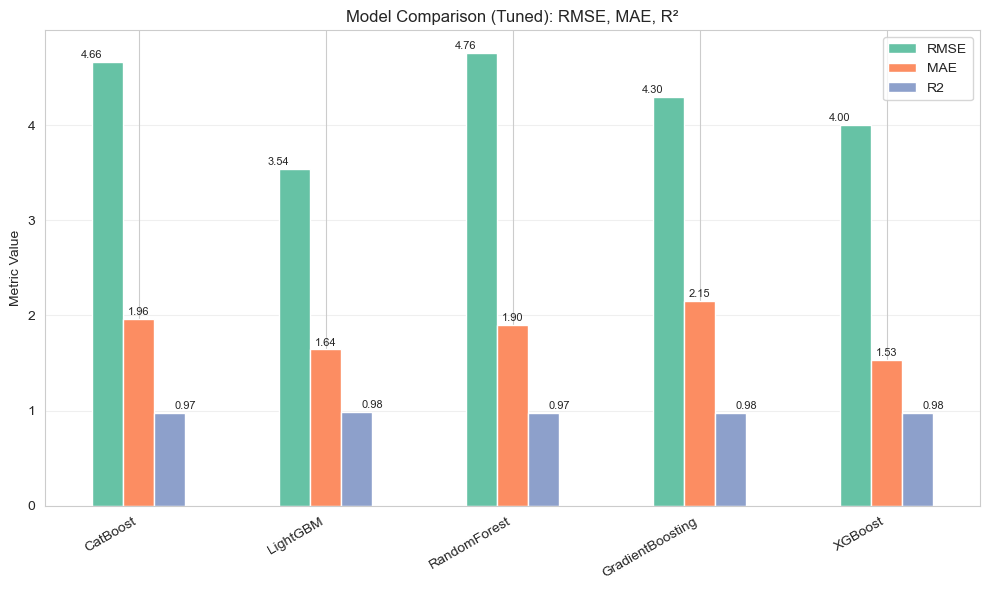

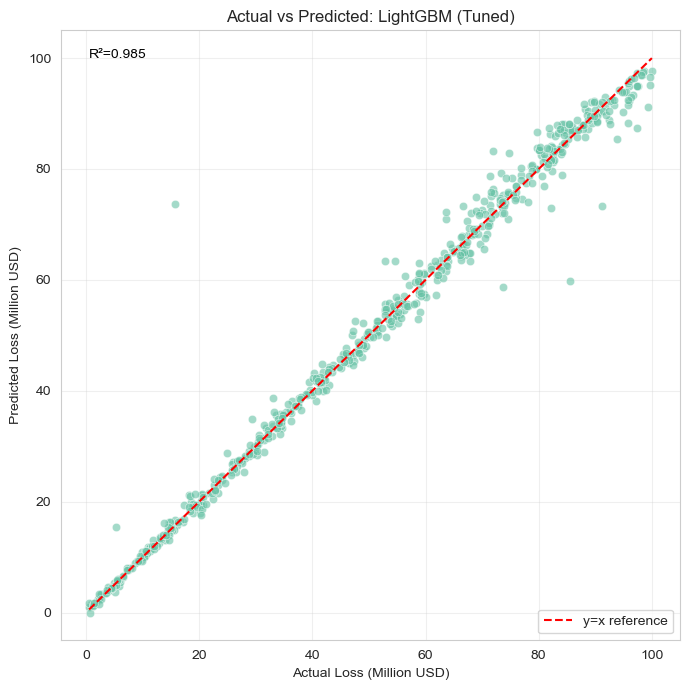

In [2]:
# Step7 - Bar Chart + Scatter Plot (Final Fixed)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# ---------------------------
# Suppress warnings globally
# ---------------------------
warnings.filterwarnings("ignore")
# Prevent joblib from probing physical cores (avoids wmic warning)
os.environ["LOKY_MAX_CPU_COUNT"] = "4"   # set to your logical core count

# ---------------------------
# Paths
# ---------------------------
PROJECT_ROOT = r"C:\Users\uthay\Desktop\CyberThreats_FinancialLoss_Prediction_ML"
PROCESSED_PATH = os.path.join(PROJECT_ROOT, "data", "processed")
MODEL_PATH = os.path.join(PROJECT_ROOT, "models")
RAW_DATA_PATH = os.path.join(PROJECT_ROOT, "data", "raw", "Global_Cybersecurity_Threats_2015-2024 (1).csv")

tuned_file = os.path.join(PROCESSED_PATH, "model_results_step4.csv")

# ---------------------------
# Load tuned results
# ---------------------------
df_tuned = pd.read_csv(tuned_file, index_col=0)

# ---------------------------
# Reload raw dataset (same as Step 4)
# ---------------------------
df_raw = pd.read_csv(RAW_DATA_PATH)

numeric_features = ['Number of Affected Users', 'Incident Resolution Time (in Hours)']
categorical_features = ['Attack Type', 'Target Industry', 'Attack Source', 'Security Vulnerability Type']
target = 'Financial Loss (in Million $)'

df_raw['AttackType_TargetIndustry'] = df_raw['Attack Type'] + "_" + df_raw['Target Industry']
categorical_features.append('AttackType_TargetIndustry')

df_raw['Loss_per_User'] = df_raw[target] / (df_raw['Number of Affected Users'] + 1)
numeric_features.append('Loss_per_User')

X = df_raw[numeric_features + categorical_features]
y = df_raw[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---------------------------
# Identify best tuned model
# ---------------------------
best_model_name = df_tuned["R2"].idxmax()
best_model = joblib.load(os.path.join(MODEL_PATH, f"{best_model_name}_tuned.joblib"))
y_pred_best = best_model.predict(X_test)   # ✅ works with raw features

# ---------------------------
# Visualization setup
# ---------------------------
sns.set_style("whitegrid")
colors = sns.color_palette("Set2", 3)

# 7.1 Bar chart: RMSE, MAE, R²
plt.figure(figsize=(10, 6))
metrics_plot = df_tuned.loc[
    ["CatBoost", "LightGBM", "RandomForest", "GradientBoosting", "XGBoost"],
    ["RMSE", "MAE", "R2"]
].round(3)

metrics_plot.plot(kind='bar', figsize=(10, 6), color=colors)
plt.title("Model Comparison (Tuned): RMSE, MAE, R²")
plt.ylabel("Metric Value")
plt.xticks(rotation=30, ha='right')
plt.grid(axis='y', alpha=0.3)

# Add data labels
for i, col in enumerate(metrics_plot.columns):
    for j, val in enumerate(metrics_plot[col]):
        plt.text(j + (i-1)*0.25, val + 0.02, f"{val:.2f}", ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# 7.2 Scatter plot: Actual vs Predicted (best tuned model)
plt.figure(figsize=(7, 7))
sns.scatterplot(x=y_test, y=y_pred_best, alpha=0.6, color=colors[0])
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='y=x reference')
r2_val = r2_score(y_test, y_pred_best)
plt.text(y_test.min(), y_test.max(), f"R²={r2_val:.3f}", fontsize=10, color='black', ha='left')
plt.xlabel("Actual Loss (Million USD)")
plt.ylabel("Predicted Loss (Million USD)")
plt.title(f"Actual vs Predicted: {best_model_name} (Tuned)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

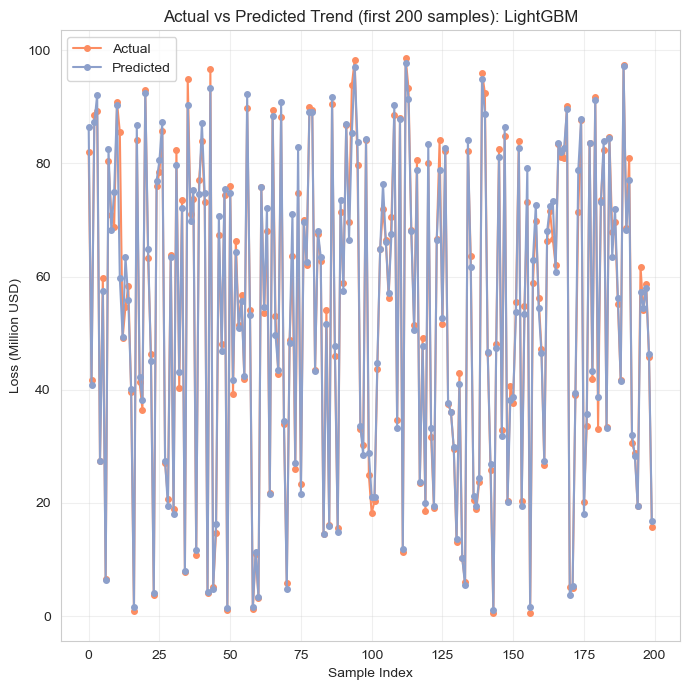

In [3]:
# Step7 - Cell 2: Trend Plot + Residual Plot

# 7.3 Trend plot: Actual vs Predicted trend (first 200 samples)
plt.figure(figsize=(7, 7))   # square shape
plt.plot(y_test[:200].values, 'o-', label='Actual', markersize=4, color=colors[1])
plt.plot(y_pred_best[:200], 'o-', label='Predicted', markersize=4, color=colors[2])
plt.title(f"Actual vs Predicted Trend (first 200 samples): {best_model_name}")
plt.xlabel("Sample Index")
plt.ylabel("Loss (Million USD)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


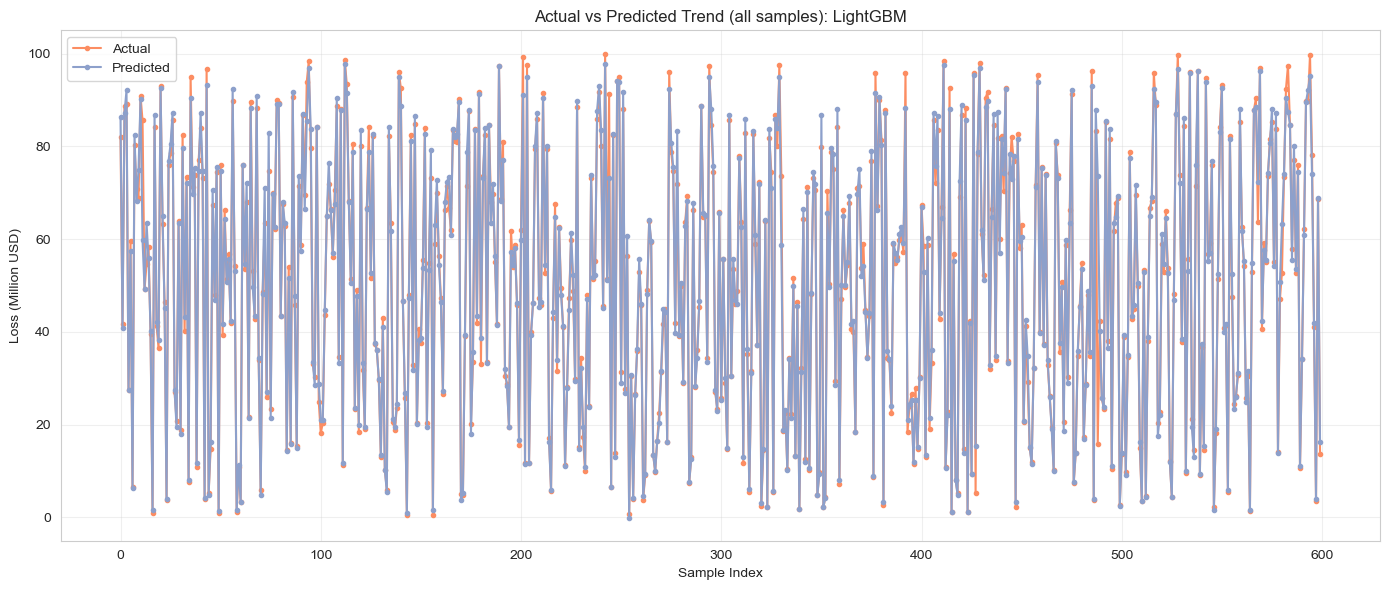

In [6]:
# 7.2 Trend plot: Actual vs Predicted trend (all rows, ~3000 samples)
plt.figure(figsize=(14, 6))   # rectangular shape: wide enough for 3000 samples
plt.plot(y_test.values, 'o-', label='Actual', markersize=3, color=colors[1])
plt.plot(y_pred_best, 'o-', label='Predicted', markersize=3, color=colors[2])
plt.title(f"Actual vs Predicted Trend (all samples): {best_model_name}")
plt.xlabel("Sample Index")
plt.ylabel("Loss (Million USD)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


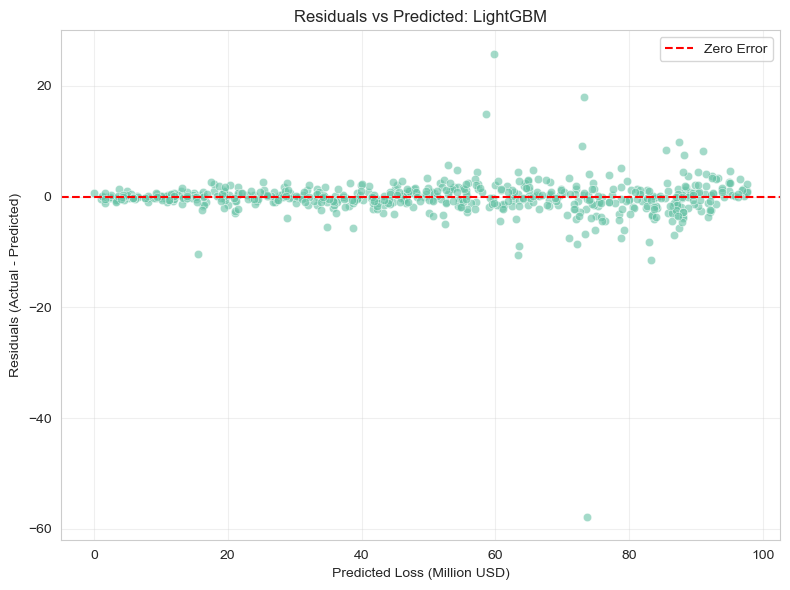

In [7]:
# Step7 - Residual Plot (Updated Style)

# Calculate residuals
residuals = y_test.values - y_pred_best

# Residuals vs Predicted plot
plt.figure(figsize=(8, 6))   # rectangular for clarity
sns.scatterplot(
    x=y_pred_best,
    y=residuals,
    alpha=0.6,
    color=colors[0]
)
plt.axhline(0, color='red', linestyle='--', label='Zero Error')
plt.title(f"Residuals vs Predicted: {best_model_name}")
plt.xlabel("Predicted Loss (Million USD)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


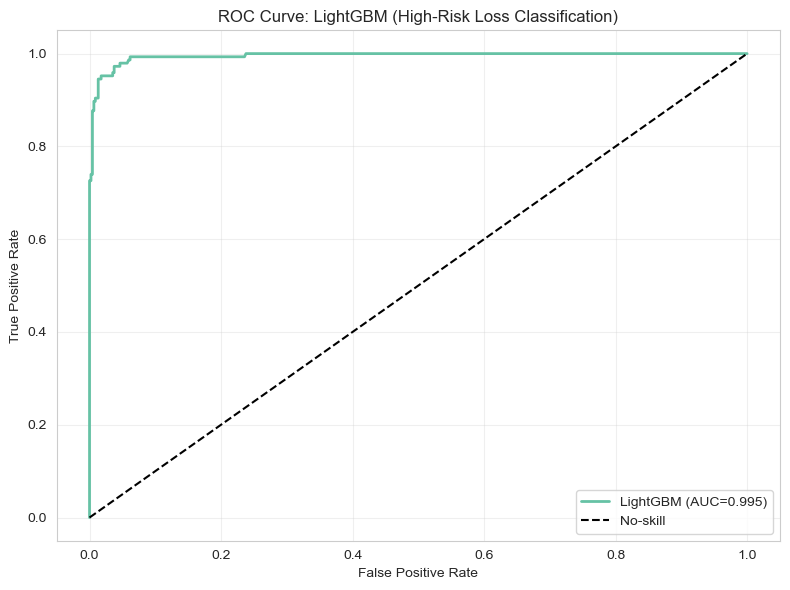

In [8]:
# Step7 - Cell 3: ROC Curve (Fixed)

from sklearn.metrics import roc_curve, roc_auc_score

# Define threshold: top 25% of financial losses considered "high-risk"
threshold = np.percentile(df_raw[target].values, 75)

# Convert actual values into binary classification labels
y_true_cls = (y_test.values >= threshold).astype(int)

# Use predicted values as risk scores (continuous)
fpr, tpr, _ = roc_curve(y_true_cls, y_pred_best)
auc_best = roc_auc_score(y_true_cls, y_pred_best)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color=colors[0], linewidth=2,
         label=f"{best_model_name} (AUC={auc_best:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label='No-skill')
plt.title(f"ROC Curve: {best_model_name} (High-Risk Loss Classification)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

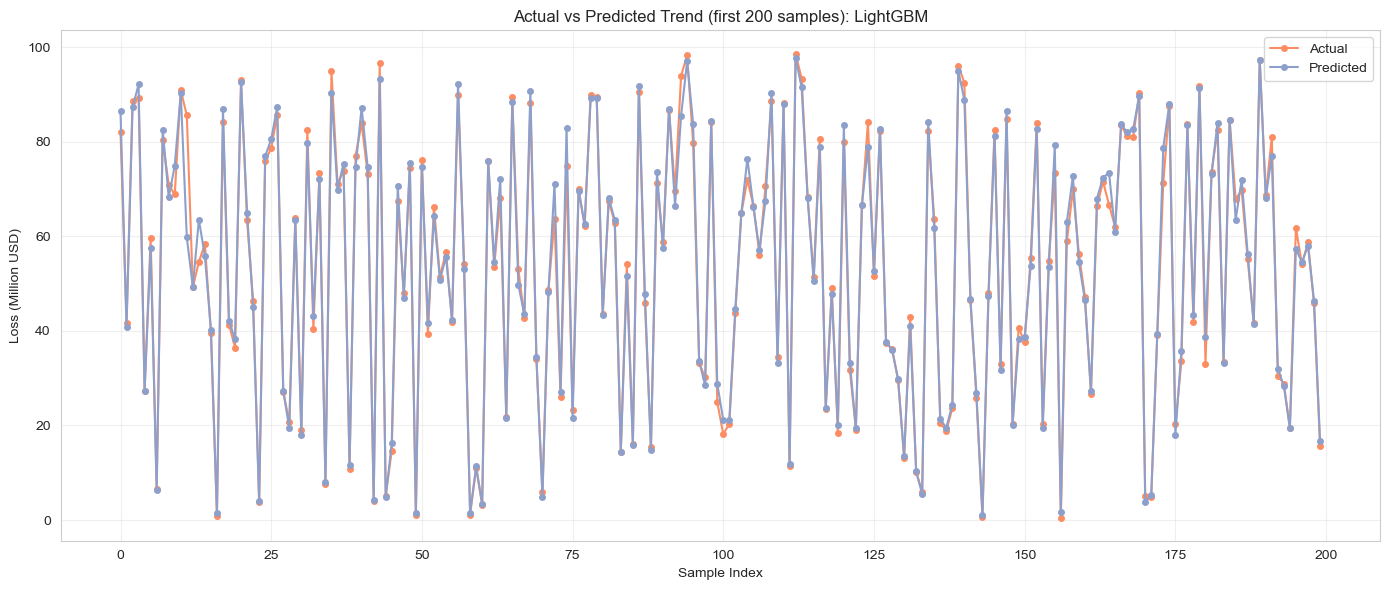

In [9]:
# Step7 - Cell 2: Trend Plot + Residual Plot

# 7.3 Trend plot: Actual vs Predicted trend (first 200 samples)
plt.figure(figsize=(14, 6))   # square shape
plt.plot(y_test[:200].values, 'o-', label='Actual', markersize=4, color=colors[1])
plt.plot(y_pred_best[:200], 'o-', label='Predicted', markersize=4, color=colors[2])
plt.title(f"Actual vs Predicted Trend (first 200 samples): {best_model_name}")
plt.xlabel("Sample Index")
plt.ylabel("Loss (Million USD)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
